# Import Library

In [1]:
import os
import io
import gdown
import joblib
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing import image
from sklearn.metrics import classification_report,confusion_matrix, ConfusionMatrixDisplay

2025-05-30 11:33:06.399307: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748604786.633166      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748604786.701529      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Get Dataset 

In [2]:
# Download zip file dataset from url

# SIBI datasets : https://drive.google.com/file/d/1S3qe0CUb0Ti5ijmquScydP8s67Gu31Zv/view?usp=sharing
!gdown 1S3qe0CUb0Ti5ijmquScydP8s67Gu31Zv

Downloading...
From (original): https://drive.google.com/uc?id=1S3qe0CUb0Ti5ijmquScydP8s67Gu31Zv
From (redirected): https://drive.google.com/uc?id=1S3qe0CUb0Ti5ijmquScydP8s67Gu31Zv&confirm=t&uuid=668cdb8c-bd30-459a-a095-85ef9a3ebd27
To: /kaggle/working/SIBI_datasets.zip
100%|█████████████████████████████████████████| 780M/780M [00:06<00:00, 118MB/s]


In [3]:
# Unzip dataset
!unzip SIBI_datasets.zip

Archive:  SIBI_datasets.zip
   creating: SIBI_datasets/
   creating: SIBI_datasets/val/
   creating: SIBI_datasets/val/U/
  inflating: SIBI_datasets/val/U/2871.jpg  
  inflating: SIBI_datasets/val/U/2555.jpg  
  inflating: SIBI_datasets/val/U/U2579.jpg  
  inflating: SIBI_datasets/val/U/U2807.jpg  
  inflating: SIBI_datasets/val/U/U2395.jpg  
  inflating: SIBI_datasets/val/U/590.jpg  
  inflating: SIBI_datasets/val/U/U1446.jpg  
  inflating: SIBI_datasets/val/U/U884.jpg  
  inflating: SIBI_datasets/val/U/2455.jpg  
  inflating: SIBI_datasets/val/U/U774.jpg  
  inflating: SIBI_datasets/val/U/U2062.jpg  
  inflating: SIBI_datasets/val/U/U208.jpg  
  inflating: SIBI_datasets/val/U/U1617.jpg  
  inflating: SIBI_datasets/val/U/2385.jpg  
  inflating: SIBI_datasets/val/U/U190.jpg  
  inflating: SIBI_datasets/val/U/U107.jpg  
  inflating: SIBI_datasets/val/U/2966.jpg  
  inflating: SIBI_datasets/val/U/U289.jpg  
  inflating: SIBI_datasets/val/U/U1612.jpg  
  inflating: SIBI_datasets/val/U/U25

In [4]:
# Delete zip file
file_path = '/kaggle/working/SIBI_datasets.zip'
if os.path.exists(file_path):
    os.remove(file_path)
    print("File SIBI_datasets.zip deleted successfully.")
else:
    print("File SIBI_datasets.zip doesn't exist.")

File SIBI_datasets.zip deleted successfully.


## Dataset Distribution

In [5]:
# Show data distribution
data_dir = '/kaggle/working/SIBI_datasets'

data = []
split_folders = ([name for name in os.listdir(data_dir)])

for split in split_folders:
    alphabets = sorted(os.listdir(os.path.join(data_dir, split)))
    for alphabet in alphabets:
        img_files = os.listdir(os.path.join(data_dir,split,alphabet))
        num_imgs = len(img_files)
        data.append({'Folder': split, 'Alfabet': alphabet, 'Jumlah': num_imgs})
df = pd.DataFrame(data)

print("-- Distribusi SIBI Dataset --\n")

x = df.pivot(index='Alfabet', columns='Folder', values='Jumlah').reset_index()
x.columns.name = None
print(x)

# Data distribution grouped by folder
groupby_df = df.groupby('Folder').agg({'Jumlah': 'sum'}).reset_index()

print(f"\n{groupby_df}")
print(f"\nTotal gambar: {groupby_df['Jumlah'].sum()}")

-- Distribusi SIBI Dataset --

   Alfabet  test  train  val
0        A   100    800  100
1        B   100    800  100
2        C   100    800  100
3        D   100    800  100
4        E   100    800  100
5        F   100    800  100
6        G   100    800  100
7        H   100    800  100
8        I   100    800  100
9        J   100    800  100
10       K   100    800  100
11       L   100    800  100
12       M   100    800  100
13       N   100    800  100
14       O   100    800  100
15       P   100    800  100
16       Q   100    800  100
17       R   100    800  100
18       S   100    800  100
19       T   100    800  100
20       U   100    800  100
21       V   100    800  100
22       W   100    800  100
23       X   100    800  100
24       Y   100    800  100
25       Z   100    800  100

  Folder  Jumlah
0   test    2600
1  train   20800
2    val    2600

Total gambar: 26000


# Load and Preprocess Dataset

In [6]:
# Load and Preprocess Dataset
image_size = (224, 224)
batch_size = 32

train_dir = data_dir +'/train/'
val_dir = data_dir +'/val/'
test_dir = data_dir +'/test/'

train_data = tf.keras.utils.image_dataset_from_directory(directory=train_dir,
                                                          label_mode='categorical',
                                                          image_size=image_size,
                                                          batch_size=batch_size,
                                                          shuffle=True,
                                                          seed=42)


val_data = tf.keras.utils.image_dataset_from_directory(directory=val_dir,
                                                        label_mode='categorical',
                                                        image_size=image_size,
                                                        batch_size=batch_size,
                                                        shuffle=False)

test_data = tf.keras.utils.image_dataset_from_directory(directory=test_dir,
                                                        label_mode='categorical',
                                                        image_size=image_size,
                                                        batch_size=batch_size,
                                                        shuffle=False)


num_classes = len(train_data.class_names)
class_names = train_data.class_names

print(f"\nClasses {num_classes}: {class_names}")

train_data = train_data.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_data = val_data.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_data = test_data.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

Found 20800 files belonging to 26 classes.


I0000 00:00:1748604823.192208      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1748604823.192861      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Found 2600 files belonging to 26 classes.
Found 2600 files belonging to 26 classes.

Classes 26: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


# Data Augmentation Layer

In [7]:
# Data Augmentation
data_augmentation = tf.keras.Sequential([tf.keras.layers.RandomZoom(0.2),
                                         tf.keras.layers.RandomRotation(0.03),
                                         tf.keras.layers.RandomTranslation(0.1, 0.1),
                                         tf.keras.layers.RandomBrightness([-0.3,0.3]),
                                         tf.keras.layers.RandomContrast(0.2),
                                         tf.keras.layers.RandomFlip("horizontal")])

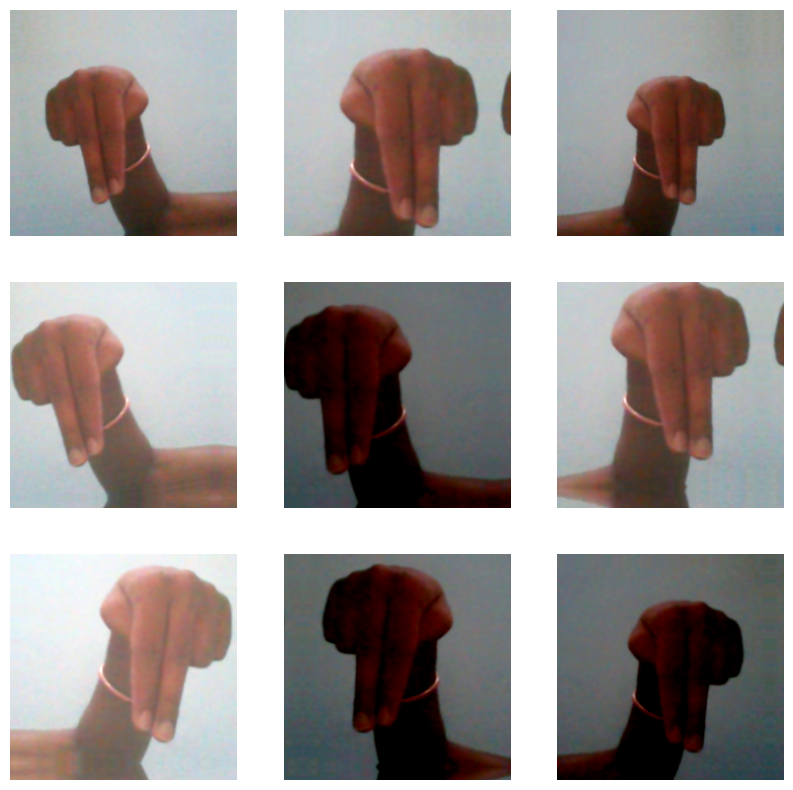

In [8]:
for image, _ in train_data.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

# Help Functions

## Create Model for Transfer Learning

In [9]:
def base_models(base):
    if base == 'resnet':
        print("Instantiating ResNet50 model...")
        base_model = tf.keras.applications.ResNet50(include_top=False,
                            weights='imagenet', input_shape=(224,224,3))
        base_model.trainable = False
        
        preprocess_input = tf.keras.applications.resnet.preprocess_input
        
    elif base == 'densenet':
        print("Instantiating DenseNet121 model...")
        base_model = tf.keras.applications.DenseNet121(include_top=False,
                            weights='imagenet', input_shape=(224,224,3))
        base_model.trainable = False
        
        preprocess_input = tf.keras.applications.densenet.preprocess_input
        
    elif base == 'mobilenetv2':
        print("Instantiating MobileNetV2 model...")
        base_model = tf.keras.applications.MobileNetV2(include_top=False,
                            weights='imagenet', input_shape=(224,224,3))
        base_model.trainable = False
        
        preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
    else:
        print("Base model not available")
    return base_model, preprocess_input
    
def custom_tlmodel(num_classes, base, dense_layer_units=None):
    base_model, preprocess_input = base_models(base)
    
    inputs = tf.keras.Input(shape=(224, 224, 3))
    x = data_augmentation(inputs)
    x = preprocess_input(x)
    x = base_model(x, training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    if dense_layer_units:
        print(f"Adding additional dense layers with units: {dense_layer_units}")
        for units in dense_layer_units:
            x = tf.keras.layers.Dense(units, activation='relu')(x)
                
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
    model = tf.keras.Model(inputs, outputs)
    
    model.summary(show_trainable=True)

    print(f"\nCreate model with base model: {base}, dense layer: {dense_layer_units}, classes: {num_classes}")
    
    return model

## Model Training and Visualization 

In [10]:
def train_model(model, train_data, val_data, epoch):
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    lr_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                                                       patience=3,verbose=1, min_lr=0.0)
    
    print("\nStart model training...\n")
    history = model.fit(train_data,
                          validation_data=val_data,
                          epochs=epoch,
                          verbose=1,
                          callbacks=[lr_callback])
    print("\nModel training completed.\n")
    return model, history

def visualize_history(history):
    accuracy = history.history.get('accuracy')
    val_accuracy = history.history.get('val_accuracy')
    
    loss = history.history.get('loss')
    val_loss = history.history.get('val_loss')
    
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(accuracy, label='Training Accuracy')
    plt.plot(val_accuracy, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.show()

## Model Evaluation

In [11]:
#  evaluate model accuracy on test_data
def evaluate_model(model, test_data):
    testLoss, testAcc = model.evaluate(test_data, verbose=1)
    print(f'Accuracy on test data: {testAcc:.4f}')
    print(f'Loss on test data: {testLoss:.4f}\n')

# use model to make prediction on test_data
def predict_model(model, test_data, class_names):
    predictions = model.predict(test_data, verbose=1)
    predicted_indices = tf.argmax(predictions, axis=1).numpy()
    
    predicted_labels = []
    for predicted_class_index in predicted_indices:
        predicted_label_name = class_names[predicted_class_index]
        predicted_labels.append(predicted_label_name)

    true_labels = []
    for images, labels in test_data:
        for one_hot_label in labels.numpy():
            class_index = tf.argmax(one_hot_label).numpy()
            true_label_name = class_names[class_index]
            true_labels.append(true_label_name)
    return true_labels, predicted_labels

# visualize confusion matrix
def visualize_prediction(true_labels, predicted_labels, class_names):
    cm = confusion_matrix(true_labels, predicted_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    fig, ax = plt.subplots(figsize=(12,10))
    disp.plot(ax=ax, cmap=plt.cm.Blues)
    plt.title('Confusion Matrix', fontsize=15, pad=20)
    plt.xlabel('Predicted Label', fontsize=11)
    plt.ylabel('Actual Label', fontsize=11)
    plt.show()

#  print model performance evaluation
def print_evaluation(model, test_data, class_names):
    evaluate_model(model, test_data)
    true_labels, predicted_labels = predict_model(model, test_data, class_names)
    print("\nClassification Report :")
    print(classification_report(true_labels, predicted_labels), "\n")
    visualize_prediction(true_labels, predicted_labels, class_names)

# save the model
def save_model(model, filename):
    joblib.dump(model, filename)

## Images Prediction

In [12]:
image_directory = '/kaggle/input/new-predict'

# use model to predict new images
def predict_images(model_file, class_names, image_directory):
    # Load a model
    print(f"Load model {model_file}")
    model = joblib.load(model_file)
    
    print(f"Searching for images in: '{image_directory}'")
    # Check if the directory exists
    if not os.path.isdir(image_directory):
        print(f"Error: Directory '{image_directory}' not found.")
        return

    # List all files in the specified directory
    image_files = [f for f in os.listdir(image_directory) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp'))]

    if not image_files:
        print(f"No image files found in '{image_directory}'. Please ensure the directory contains images with common extensions.")
        return

    print(f"Found {len(image_files)} image(s).")
    
    # Load the images
    for filename in image_files:
        file_path = os.path.join(image_directory, filename)
        print(f"\n--- Processing file: \"{file_path}\" ---")
        img_bytes = tf.io.read_file(file_path)
        img = tf.io.decode_image(img_bytes, channels=3)

        plt.figure(figsize=(3, 3))
        plt.imshow(img.numpy().astype("uint8"))
        plt.axis('off')
        plt.show()
        
        # Preprocess the image
        img = tf.image.resize(img, [224, 224])
        img_array = tf.expand_dims(img, axis=0)
    
        print("Image preprocessed. Making prediction...")
        predictions = model.predict(img_array)

        # Get the top 3 predicted class indices and confidences
        top_3_indices = np.argsort(predictions[0])[-3:][::-1]

        print(f"--- Prediction Results for \"{filename}\" ---")
        print("Top 3 Predictions:")
        for i, predicted_index in enumerate(top_3_indices):
            predicted_class = class_names[predicted_index]
            confidence = predictions[0][predicted_index] * 100
            print(f"  {i+1}. {predicted_class}: {confidence:.2f}%")

# Pre-trained Base Model

## ResNet50

Instantiating ResNet50 model...
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)           ┃ Output Shape         ┃      Param # ┃ Connected to        ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ input_layer_2          │ (None, 224, 224, 3)  │            0 │ -                   │    -    │
│ (InputLayer)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ sequential             │ (None, 224, 224, 3)  │            0 │ input_layer_2[0][0] │    -    │
│ (Sequential)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ get_item (GetItem)     │ (None, 224, 224)     │            0 │ sequential[0][0]    │    -    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ get_item_1 (GetItem)   │ (None, 224, 224)     │            0 │ sequential[0][0]    │    -    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ get_item_2 (GetItem)   │ (None, 224, 224)     │            0 │ sequential[0][0]    │    -    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ stack (Stack)          │ (None, 224, 224, 3)  │            0 │ get_item[0][0],     │    -    │
│                        │                      │              │ get_item_1[0][0],   │         │
│                        │                      │              │ get_item_2[0][0]    │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ add (Add)              │ (None, 224, 224, 3)  │            0 │ stack[0][0]         │    -    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ resnet50 (Functional)  │ (None, 7, 7, 2048)   │   23,587,712 │ add[0][0]           │    N    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ global_average_poolin… │ (None, 2048)         │            0 │ resnet50[0][0]      │    -    │
│ (GlobalAveragePooling… │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ dense (Dense)          │ (None, 26)           │       53,274 │ global_average_poo… │    Y    │
└────────────────────────┴──────────────────────┴──────────────┴─────────────────────┴─────────┘

 Total params: 23,640,986 (90.18 MB)

 Trainable params: 53,274 (208.10 KB)

 Non-trainable params: 23,587,712 (89.98 MB)


Create model with base model: resnet, dense layer: None, classes: 26

Start model training...

Epoch 1/10


I0000 00:00:1748604843.736256      72 cuda_dnn.cc:529] Loaded cuDNN version 90300


650/650 ━━━━━━━━━━━━━━━━━━━━ 121s 164ms/step - accuracy: 0.8341 - loss: 0.7778 - val_accuracy: 0.9946 - val_loss: 0.0499 - learning_rate: 0.0010
Epoch 2/10
650/650 ━━━━━━━━━━━━━━━━━━━━ 97s 150ms/step - accuracy: 0.9957 - loss: 0.0456 - val_accuracy: 0.9965 - val_loss: 0.0236 - learning_rate: 0.0010
Epoch 3/10
650/650 ━━━━━━━━━━━━━━━━━━━━ 107s 164ms/step - accuracy: 0.9965 - loss: 0.0253 - val_accuracy: 0.9950 - val_loss: 0.0191 - learning_rate: 0.0010
Epoch 4/10
650/650 ━━━━━━━━━━━━━━━━━━━━ 106s 162ms/step - accuracy: 0.9976 - loss: 0.0164 - val_accuracy: 0.9969 - val_loss: 0.0097 - learning_rate: 0.0010
Epoch 5/10
650/650 ━━━━━━━━━━━━━━━━━━━━ 107s 164ms/step - accuracy: 0.9977 - loss: 0.0136 - val_accuracy: 0.9969 - val_loss: 0.0137 - learning_rate: 0.0010
Epoch 6/10
650/650 ━━━━━━━━━━━━━━━━━━━━ 105s 162ms/step - accuracy: 0.9974 - loss: 0.0115 - val_accuracy: 0.9992 - val_loss: 0.0057 - learning_rate: 0.0010
Epoch 7/10
650/650 ━━━━━━━━━━━━━━━━━━━━ 105s 162ms/step - accuracy: 0.9983 -

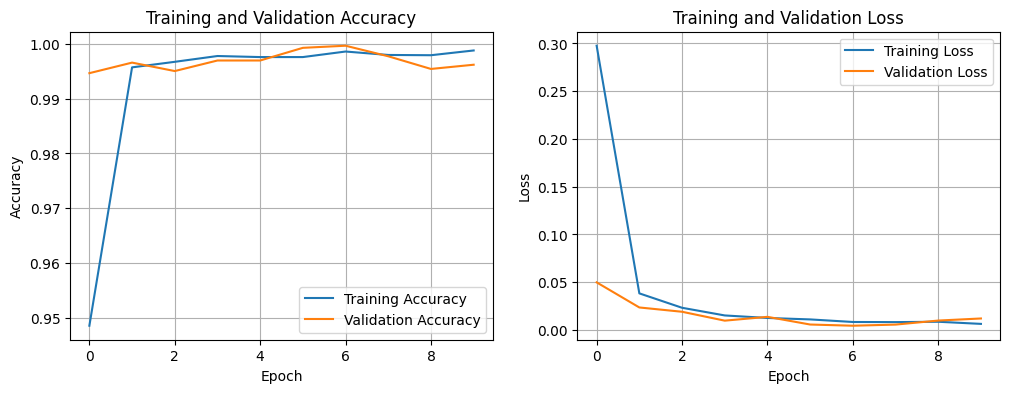

82/82 ━━━━━━━━━━━━━━━━━━━━ 12s 140ms/step - accuracy: 0.9987 - loss: 0.0063
Accuracy on test data: 0.9977
Loss on test data: 0.0084

82/82 ━━━━━━━━━━━━━━━━━━━━ 16s 169ms/step

Classification Report :
              precision    recall  f1-score   support

           A       1.00      1.00      1.00       100
           B       1.00      1.00      1.00       100
           C       1.00      1.00      1.00       100
           D       1.00      1.00      1.00       100
           E       1.00      1.00      1.00       100
           F       1.00      1.00      1.00       100
           G       1.00      1.00      1.00       100
           H       1.00      1.00      1.00       100
           I       1.00      1.00      1.00       100
           J       1.00      1.00      1.00       100
           K       1.00      0.97      0.98       100
           L       1.00      1.00      1.00       100
           M       1.00      1.00      1.00       100
           N       1.00      1.00      1.00

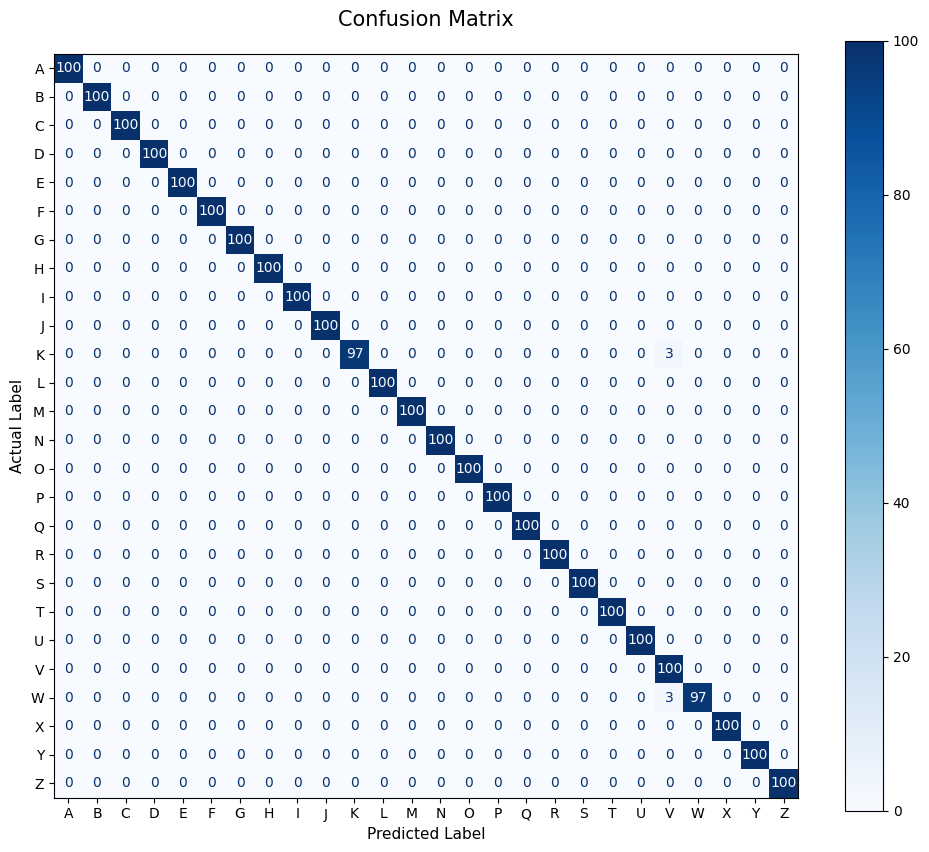

In [13]:
resnet_base = custom_tlmodel(num_classes, base='resnet', dense_layer_units=None)
resnet_ori, resnet_ori_history = train_model(resnet_base, train_data, val_data, epoch=10)
visualize_history(resnet_ori_history)
print_evaluation(resnet_ori, test_data, class_names)

Load model resnet_ori.pkl
Searching for images in: '/kaggle/input/new-predict'
Found 4 image(s).

--- Processing file: "/kaggle/input/new-predict/B (4).jpg" ---


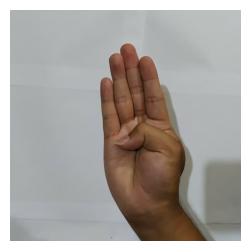

Image preprocessed. Making prediction...
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
--- Prediction Results for "B (4).jpg" ---
Top 3 Predictions:
  1. E: 95.61%
  2. U: 2.18%
  3. B: 1.85%

--- Processing file: "/kaggle/input/new-predict/A (4).jpg" ---


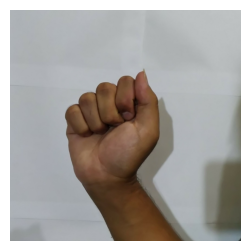

Image preprocessed. Making prediction...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
--- Prediction Results for "A (4).jpg" ---
Top 3 Predictions:
  1. A: 99.40%
  2. E: 0.53%
  3. T: 0.04%

--- Processing file: "/kaggle/input/new-predict/R (5).jpg" ---


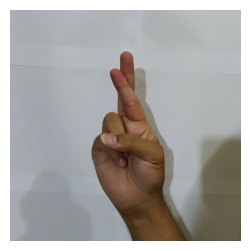

Image preprocessed. Making prediction...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
--- Prediction Results for "R (5).jpg" ---
Top 3 Predictions:
  1. J: 42.51%
  2. U: 19.20%
  3. R: 14.16%

--- Processing file: "/kaggle/input/new-predict/U (3).jpg" ---


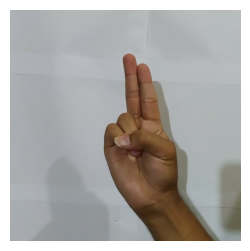

Image preprocessed. Making prediction...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
--- Prediction Results for "U (3).jpg" ---
Top 3 Predictions:
  1. U: 98.46%
  2. X: 0.43%
  3. Z: 0.21%


In [14]:
save_model(resnet_ori, 'resnet_ori.pkl')
predict_images('resnet_ori.pkl', class_names, image_directory)

## DenseNet

Instantiating DenseNet121 model...
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)                        ┃ Output Shape                 ┃       Param # ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ input_layer_4 (InputLayer)          │ (None, 224, 224, 3)          │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ sequential (Sequential)             │ (None, 224, 224, 3)          │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ true_divide (TrueDivide)            │ (None, 224, 224, 3)          │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ add_1 (Add)                         │ (None, 224, 224, 3)          │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ true_divide_1 (TrueDivide)          │ (None, 224, 224, 3)          │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ densenet121 (Functional)            │ (None, 7, 7, 1024)           │     7,037,504 │    N    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ global_average_pooling2d_1          │ (None, 1024)                 │             0 │    -    │
│ (GlobalAveragePooling2D)            │                              │               │         │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ dense_1 (Dense)                     │ (None, 26)                   │        26,650 │    Y    │
└─────────────────────────────────────┴──────────────────────────────┴───────────────┴─────────┘

 Total params: 7,064,154 (26.95 MB)

 Trainable params: 26,650 (104.10 KB)

 Non-trainable params: 7,037,504 (26.85 MB)


Create model with base model: densenet, dense layer: None, classes: 26

Start model training...

Epoch 1/10
650/650 ━━━━━━━━━━━━━━━━━━━━ 136s 177ms/step - accuracy: 0.7242 - loss: 1.3729 - val_accuracy: 0.9808 - val_loss: 0.1882 - learning_rate: 0.0010
Epoch 2/10
650/650 ━━━━━━━━━━━━━━━━━━━━ 108s 167ms/step - accuracy: 0.9906 - loss: 0.1477 - val_accuracy: 0.9904 - val_loss: 0.0813 - learning_rate: 0.0010
Epoch 3/10
650/650 ━━━━━━━━━━━━━━━━━━━━ 108s 166ms/step - accuracy: 0.9950 - loss: 0.0719 - val_accuracy: 0.9919 - val_loss: 0.0525 - learning_rate: 0.0010
Epoch 4/10
650/650 ━━━━━━━━━━━━━━━━━━━━ 108s 166ms/step - accuracy: 0.9964 - loss: 0.0462 - val_accuracy: 0.9931 - val_loss: 0.0398 - learning_rate: 0.0010
Epoch 5/10
650/650 ━━━━━━━━━━━━━━━━━━━━ 108s 167ms/step - accuracy: 0.9974 - loss: 0.0325 - val_accuracy: 0.9938 - val_loss: 0.0324 - learning_rate: 0.0010
Epoch 6/10
650/650 ━━━━━━━━━━━━━━━━━━━━ 108s 167ms/step - accuracy: 0.9984 - loss: 0.0248 - val_accuracy: 0.9946 - val_los

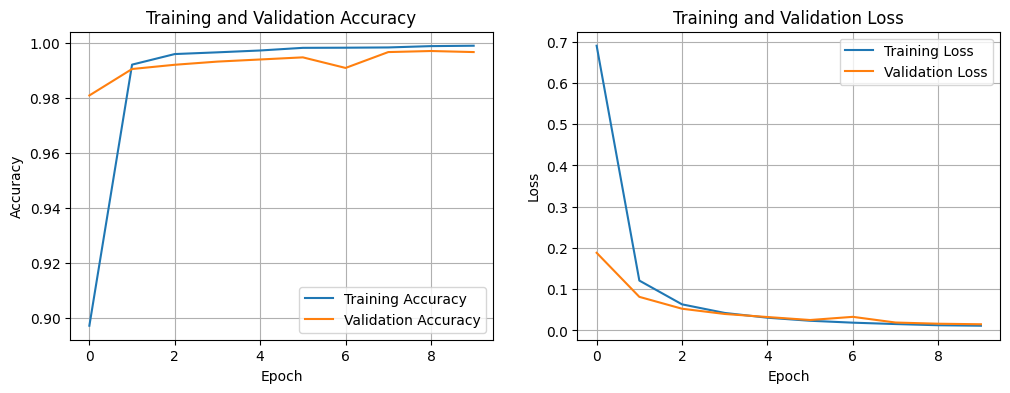

82/82 ━━━━━━━━━━━━━━━━━━━━ 12s 141ms/step - accuracy: 0.9992 - loss: 0.0088
Accuracy on test data: 0.9973
Loss on test data: 0.0145

82/82 ━━━━━━━━━━━━━━━━━━━━ 22s 201ms/step

Classification Report :
              precision    recall  f1-score   support

           A       1.00      1.00      1.00       100
           B       1.00      1.00      1.00       100
           C       1.00      1.00      1.00       100
           D       1.00      1.00      1.00       100
           E       1.00      1.00      1.00       100
           F       1.00      1.00      1.00       100
           G       1.00      1.00      1.00       100
           H       1.00      1.00      1.00       100
           I       1.00      1.00      1.00       100
           J       1.00      1.00      1.00       100
           K       1.00      1.00      1.00       100
           L       1.00      1.00      1.00       100
           M       0.99      1.00      1.00       100
           N       1.00      0.99      0.99

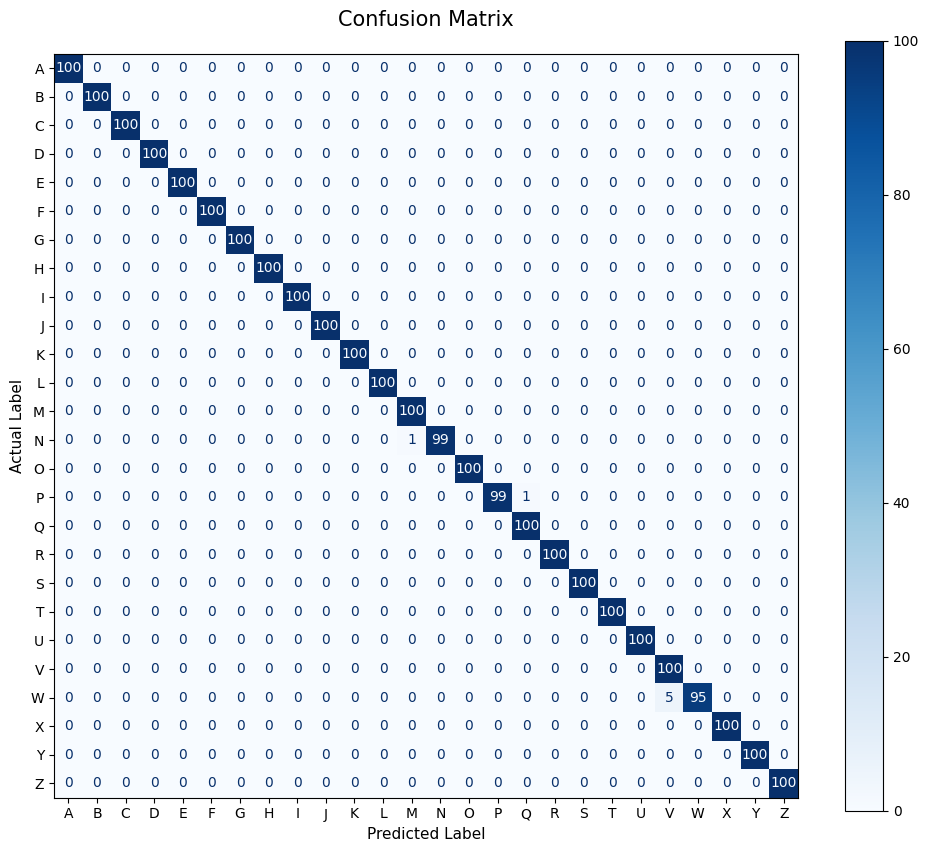

In [15]:
densenet_base = custom_tlmodel(num_classes, base='densenet', dense_layer_units=None)
densenet_ori, densenet_ori_history = train_model(densenet_base, train_data, val_data, epoch=10)
visualize_history(densenet_ori_history)
print_evaluation(densenet_ori, test_data, class_names)

Load model densenet_ori.pkl
Searching for images in: '/kaggle/input/new-predict'
Found 4 image(s).

--- Processing file: "/kaggle/input/new-predict/B (4).jpg" ---


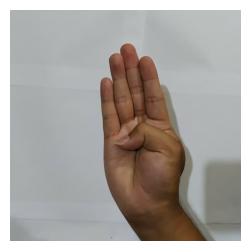

Image preprocessed. Making prediction...
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
--- Prediction Results for "B (4).jpg" ---
Top 3 Predictions:
  1. E: 71.70%
  2. B: 26.75%
  3. X: 0.58%

--- Processing file: "/kaggle/input/new-predict/A (4).jpg" ---


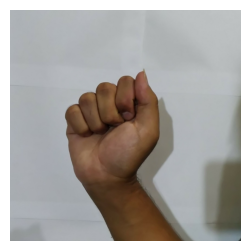

Image preprocessed. Making prediction...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
--- Prediction Results for "A (4).jpg" ---
Top 3 Predictions:
  1. E: 71.67%
  2. M: 9.72%
  3. A: 6.06%

--- Processing file: "/kaggle/input/new-predict/R (5).jpg" ---


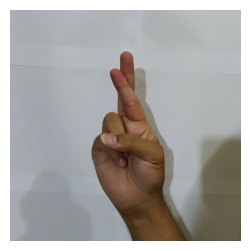

Image preprocessed. Making prediction...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
--- Prediction Results for "R (5).jpg" ---
Top 3 Predictions:
  1. X: 99.09%
  2. L: 0.26%
  3. I: 0.26%

--- Processing file: "/kaggle/input/new-predict/U (3).jpg" ---


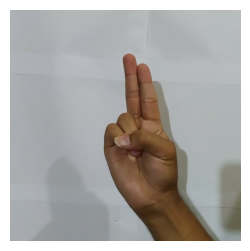

Image preprocessed. Making prediction...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
--- Prediction Results for "U (3).jpg" ---
Top 3 Predictions:
  1. X: 46.21%
  2. J: 15.87%
  3. K: 15.73%


In [16]:
save_model(densenet_ori, 'densenet_ori.pkl')
predict_images('densenet_ori.pkl', class_names, image_directory)

## MobileNetv2

Instantiating MobileNetV2 model...
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)                        ┃ Output Shape                 ┃       Param # ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ input_layer_6 (InputLayer)          │ (None, 224, 224, 3)          │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ sequential (Sequential)             │ (None, 224, 224, 3)          │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ true_divide_2 (TrueDivide)          │ (None, 224, 224, 3)          │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ subtract (Subtract)                 │ (None, 224, 224, 3)          │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ mobilenetv2_1.00_224 (Functional)   │ (None, 7, 7, 1280)           │     2,257,984 │    N    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ global_average_pooling2d_2          │ (None, 1280)                 │             0 │    -    │
│ (GlobalAveragePooling2D)            │                              │               │         │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ dense_2 (Dense)                     │ (None, 26)                   │        33,306 │    Y    │
└─────────────────────────────────────┴──────────────────────────────┴───────────────┴─────────┘

 Total params: 2,291,290 (8.74 MB)

 Trainable params: 33,306 (130.10 KB)

 Non-trainable params: 2,257,984 (8.61 MB)


Create model with base model: mobilenetv2, dense layer: None, classes: 26

Start model training...

Epoch 1/10
650/650 ━━━━━━━━━━━━━━━━━━━━ 51s 68ms/step - accuracy: 0.8367 - loss: 0.7775 - val_accuracy: 0.9954 - val_loss: 0.0553 - learning_rate: 0.0010
Epoch 2/10
650/650 ━━━━━━━━━━━━━━━━━━━━ 40s 62ms/step - accuracy: 0.9944 - loss: 0.0444 - val_accuracy: 0.9981 - val_loss: 0.0254 - learning_rate: 0.0010
Epoch 3/10
650/650 ━━━━━━━━━━━━━━━━━━━━ 40s 62ms/step - accuracy: 0.9974 - loss: 0.0226 - val_accuracy: 0.9996 - val_loss: 0.0151 - learning_rate: 0.0010
Epoch 4/10
650/650 ━━━━━━━━━━━━━━━━━━━━ 40s 62ms/step - accuracy: 0.9975 - loss: 0.0159 - val_accuracy: 0.9988 - val_loss: 0.0133 - learning_rate: 0.0010
Epoch 5/10
650/650 ━━━━━━━━━━━━━━━━━━━━ 40s 62ms/step - accuracy: 0.9978 - loss: 0.0127 - val_accuracy: 0.9988 - val_loss: 0.0084 - learning_rate: 0.0010
Epoch 6/10
650/650 ━━━━━━━━━━━━━━━━━━━━ 40s 62ms/step - accuracy: 0.9982 - loss: 0.0095 - val_accuracy: 0.9996 - val_loss: 0.0053

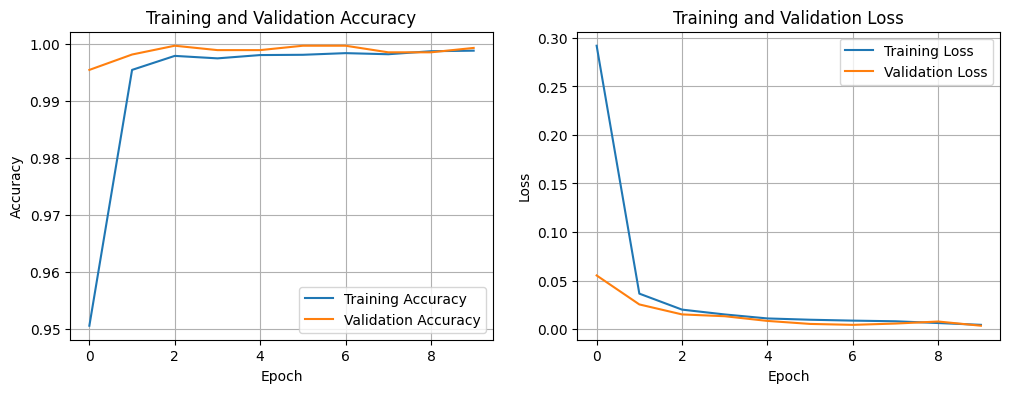

82/82 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - accuracy: 0.9984 - loss: 0.0058
Accuracy on test data: 0.9985
Loss on test data: 0.0053

82/82 ━━━━━━━━━━━━━━━━━━━━ 7s 66ms/step

Classification Report :
              precision    recall  f1-score   support

           A       1.00      1.00      1.00       100
           B       1.00      1.00      1.00       100
           C       0.99      1.00      1.00       100
           D       1.00      1.00      1.00       100
           E       1.00      1.00      1.00       100
           F       1.00      0.99      0.99       100
           G       0.99      1.00      1.00       100
           H       1.00      0.99      0.99       100
           I       1.00      0.99      0.99       100
           J       1.00      1.00      1.00       100
           K       1.00      1.00      1.00       100
           L       1.00      1.00      1.00       100
           M       1.00      1.00      1.00       100
           N       1.00      1.00      1.00    

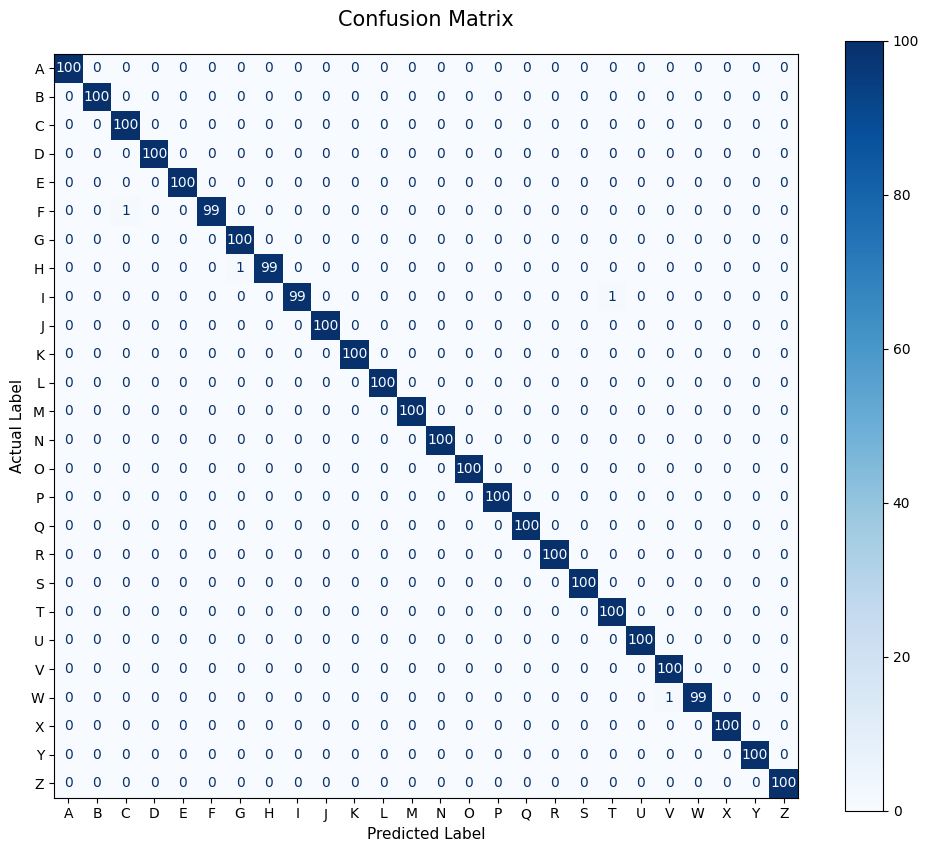

In [17]:
mobilenetv2_base = custom_tlmodel(num_classes, base='mobilenetv2', dense_layer_units=None)
mobilenetv2_ori, mobilenetv2_ori_history = train_model(mobilenetv2_base, train_data, val_data, epoch=10)
visualize_history(mobilenetv2_ori_history)
print_evaluation(mobilenetv2_ori, test_data, class_names)


Load model mobilenetv2_ori.pkl
Searching for images in: '/kaggle/input/new-predict'
Found 4 image(s).

--- Processing file: "/kaggle/input/new-predict/B (4).jpg" ---


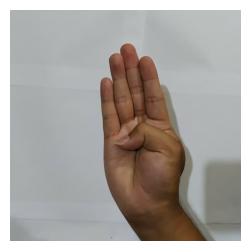

Image preprocessed. Making prediction...
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
--- Prediction Results for "B (4).jpg" ---
Top 3 Predictions:
  1. B: 74.36%
  2. E: 19.21%
  3. U: 2.81%

--- Processing file: "/kaggle/input/new-predict/A (4).jpg" ---


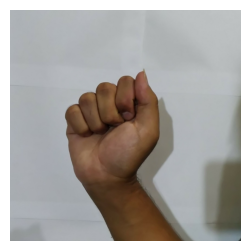

Image preprocessed. Making prediction...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
--- Prediction Results for "A (4).jpg" ---
Top 3 Predictions:
  1. A: 70.17%
  2. L: 21.08%
  3. J: 7.42%

--- Processing file: "/kaggle/input/new-predict/R (5).jpg" ---


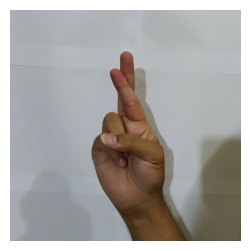

Image preprocessed. Making prediction...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
--- Prediction Results for "R (5).jpg" ---
Top 3 Predictions:
  1. U: 56.08%
  2. X: 29.76%
  3. L: 8.64%

--- Processing file: "/kaggle/input/new-predict/U (3).jpg" ---


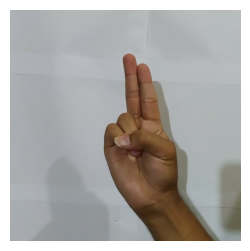

Image preprocessed. Making prediction...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
--- Prediction Results for "U (3).jpg" ---
Top 3 Predictions:
  1. U: 99.07%
  2. L: 0.73%
  3. K: 0.15%


In [18]:
save_model(mobilenetv2_ori, 'mobilenetv2_ori.pkl')
predict_images('mobilenetv2_ori.pkl', class_names, image_directory)

# CNN Model Architectures

## CNN 1

In [19]:
cnn1 = tf.keras.Sequential([
              tf.keras.Input(shape=(224, 224, 3)),
              data_augmentation,
              tf.keras.layers.Rescaling(1./255),
              tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
              tf.keras.layers.MaxPooling2D(),
              tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
              tf.keras.layers.MaxPooling2D(),
              tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
              tf.keras.layers.MaxPooling2D(),
              tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
              tf.keras.layers.MaxPooling2D(),
              tf.keras.layers.Flatten(),
              tf.keras.layers.Dense(128, activation='relu'),
              tf.keras.layers.Dense(num_classes, activation='softmax')
            ])
cnn1.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling (Rescaling)                │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 112, 112, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 56, 56, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 28, 28, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 128)                 │       1,605,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 26)                  │           3,354 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,674,682 (6.39 MB)

 Trainable params: 1,674,682 (6.39 MB)

 Non-trainable params: 0 (0.00 B)


Start model training...

Epoch 1/20
650/650 ━━━━━━━━━━━━━━━━━━━━ 32s 40ms/step - accuracy: 0.2168 - loss: 2.6239 - val_accuracy: 0.8835 - val_loss: 0.3474 - learning_rate: 0.0010
Epoch 2/20
650/650 ━━━━━━━━━━━━━━━━━━━━ 26s 40ms/step - accuracy: 0.8642 - loss: 0.4077 - val_accuracy: 0.9800 - val_loss: 0.0753 - learning_rate: 0.0010
Epoch 3/20
650/650 ━━━━━━━━━━━━━━━━━━━━ 25s 38ms/step - accuracy: 0.9238 - loss: 0.2238 - val_accuracy: 0.9892 - val_loss: 0.0418 - learning_rate: 0.0010
Epoch 4/20
650/650 ━━━━━━━━━━━━━━━━━━━━ 25s 39ms/step - accuracy: 0.9484 - loss: 0.1566 - val_accuracy: 0.9919 - val_loss: 0.0357 - learning_rate: 0.0010
Epoch 5/20
650/650 ━━━━━━━━━━━━━━━━━━━━ 25s 39ms/step - accuracy: 0.9581 - loss: 0.1284 - val_accuracy: 0.9915 - val_loss: 0.0331 - learning_rate: 0.0010
Epoch 6/20
650/650 ━━━━━━━━━━━━━━━━━━━━ 25s 39ms/step - accuracy: 0.9690 - loss: 0.0962 - val_accuracy: 0.9954 - val_loss: 0.0198 - learning_rate: 0.0010
Epoch 7/20
650/650 ━━━━━━━━━━━━━━━━━━━━ 25s 39ms/s

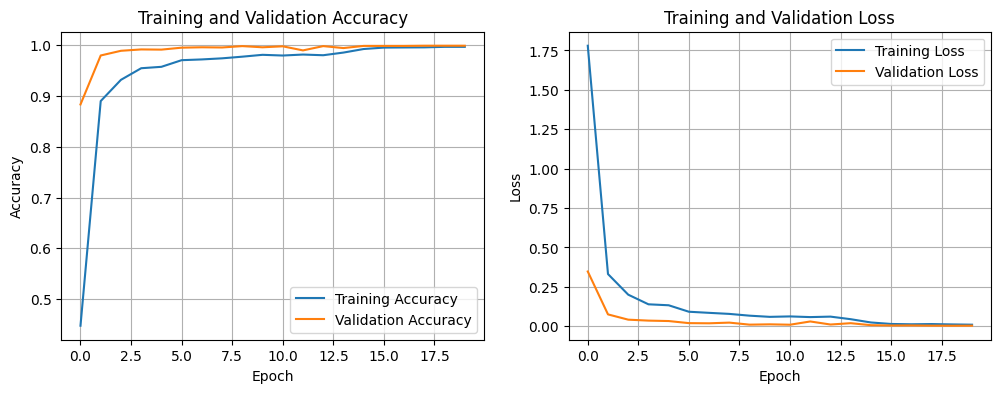

82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9987 - loss: 0.0034
Accuracy on test data: 0.9985
Loss on test data: 0.0039

82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step

Classification Report :
              precision    recall  f1-score   support

           A       1.00      1.00      1.00       100
           B       1.00      1.00      1.00       100
           C       1.00      1.00      1.00       100
           D       1.00      1.00      1.00       100
           E       1.00      1.00      1.00       100
           F       1.00      1.00      1.00       100
           G       0.99      1.00      1.00       100
           H       1.00      0.99      0.99       100
           I       1.00      1.00      1.00       100
           J       1.00      1.00      1.00       100
           K       1.00      1.00      1.00       100
           L       1.00      1.00      1.00       100
           M       1.00      0.98      0.99       100
           N       0.97      1.00      0.99    

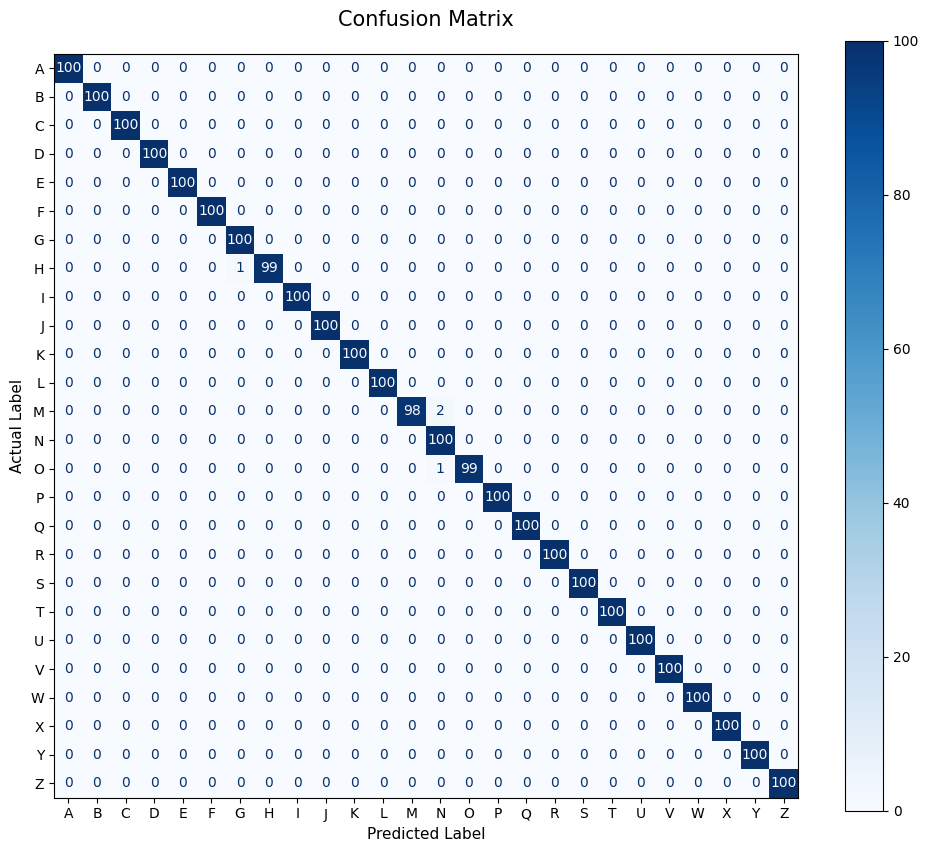

In [20]:
model_cnn1, model_cnn1_history = train_model(cnn1, train_data, val_data, epoch=20)
visualize_history(model_cnn1_history)
print_evaluation(model_cnn1, test_data, class_names)

Load model model_cnn1.pkl
Searching for images in: '/kaggle/input/new-predict'
Found 4 image(s).

--- Processing file: "/kaggle/input/new-predict/B (4).jpg" ---


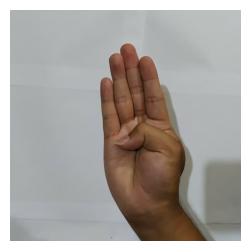

Image preprocessed. Making prediction...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step
--- Prediction Results for "B (4).jpg" ---
Top 3 Predictions:
  1. U: 100.00%
  2. R: 0.00%
  3. M: 0.00%

--- Processing file: "/kaggle/input/new-predict/A (4).jpg" ---


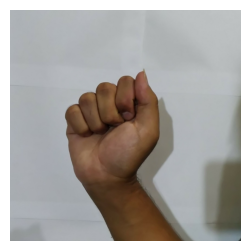

Image preprocessed. Making prediction...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
--- Prediction Results for "A (4).jpg" ---
Top 3 Predictions:
  1. X: 61.20%
  2. S: 33.14%
  3. T: 5.51%

--- Processing file: "/kaggle/input/new-predict/R (5).jpg" ---


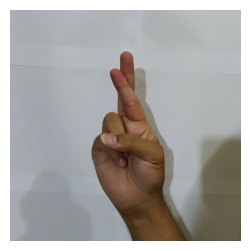

Image preprocessed. Making prediction...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
--- Prediction Results for "R (5).jpg" ---
Top 3 Predictions:
  1. V: 56.30%
  2. R: 43.38%
  3. L: 0.32%

--- Processing file: "/kaggle/input/new-predict/U (3).jpg" ---


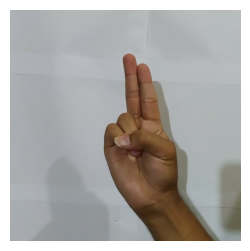

Image preprocessed. Making prediction...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
--- Prediction Results for "U (3).jpg" ---
Top 3 Predictions:
  1. U: 99.94%
  2. R: 0.06%
  3. X: 0.00%


In [21]:
save_model(model_cnn1, 'model_cnn1.pkl')
predict_images('model_cnn1.pkl', class_names, image_directory)

## CNN 2 

In [22]:
cnn2 = tf.keras.Sequential([
              tf.keras.Input(shape=(224, 224, 3)),
              data_augmentation,
              tf.keras.layers.Rescaling(1./255),
              tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
              tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
              tf.keras.layers.MaxPooling2D(),
              tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
              tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
              tf.keras.layers.MaxPooling2D(),
              tf.keras.layers.Flatten(),
              tf.keras.layers.Dense(128, activation='relu'),
              tf.keras.layers.Dense(num_classes, activation='softmax')
            ])
cnn2.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_1 (Rescaling)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 224, 224, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 112, 112, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 200704)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 128)                 │      25,690,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 26)                  │           3,354 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,759,162 (98.26 MB)

 Trainable params: 25,759,162 (98.26 MB)

 Non-trainable params: 0 (0.00 B)


Start model training...

Epoch 1/20
650/650 ━━━━━━━━━━━━━━━━━━━━ 83s 119ms/step - accuracy: 0.2082 - loss: 2.8478 - val_accuracy: 0.8319 - val_loss: 0.5418 - learning_rate: 0.0010
Epoch 2/20
650/650 ━━━━━━━━━━━━━━━━━━━━ 76s 116ms/step - accuracy: 0.7520 - loss: 0.7392 - val_accuracy: 0.9362 - val_loss: 0.1925 - learning_rate: 0.0010
Epoch 3/20
650/650 ━━━━━━━━━━━━━━━━━━━━ 75s 116ms/step - accuracy: 0.8776 - loss: 0.3571 - val_accuracy: 0.9396 - val_loss: 0.1857 - learning_rate: 0.0010
Epoch 4/20
650/650 ━━━━━━━━━━━━━━━━━━━━ 75s 116ms/step - accuracy: 0.9040 - loss: 0.3014 - val_accuracy: 0.9662 - val_loss: 0.0982 - learning_rate: 0.0010
Epoch 5/20
650/650 ━━━━━━━━━━━━━━━━━━━━ 75s 116ms/step - accuracy: 0.9320 - loss: 0.1988 - val_accuracy: 0.9635 - val_loss: 0.1038 - learning_rate: 0.0010
Epoch 6/20
650/650 ━━━━━━━━━━━━━━━━━━━━ 75s 115ms/step - accuracy: 0.9331 - loss: 0.1971 - val_accuracy: 0.9750 - val_loss: 0.0819 - learning_rate: 0.0010
Epoch 7/20
650/650 ━━━━━━━━━━━━━━━━━━━━ 75s 

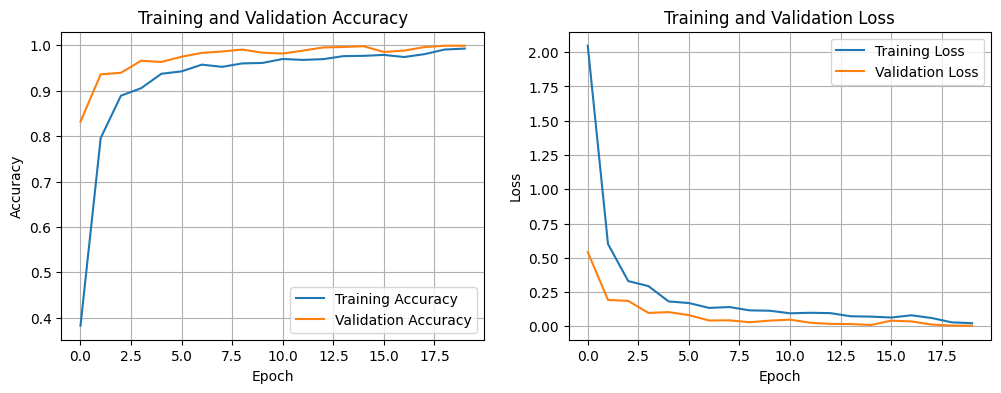

82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.9994 - loss: 0.0024
Accuracy on test data: 0.9992
Loss on test data: 0.0030

82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step

Classification Report :
              precision    recall  f1-score   support

           A       1.00      1.00      1.00       100
           B       1.00      1.00      1.00       100
           C       1.00      1.00      1.00       100
           D       1.00      1.00      1.00       100
           E       1.00      1.00      1.00       100
           F       1.00      1.00      1.00       100
           G       1.00      1.00      1.00       100
           H       1.00      1.00      1.00       100
           I       1.00      1.00      1.00       100
           J       1.00      1.00      1.00       100
           K       1.00      1.00      1.00       100
           L       1.00      1.00      1.00       100
           M       1.00      0.98      0.99       100
           N       0.98      1.00      0.99    

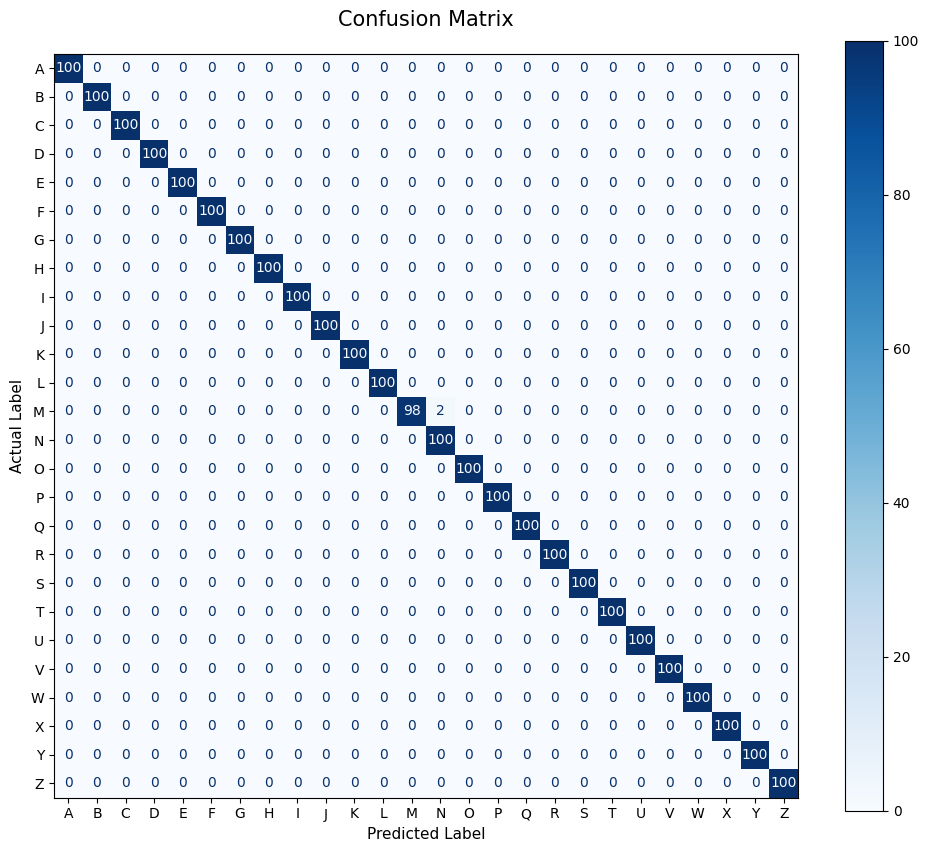

In [23]:
model_cnn2, model_cnn2_history = train_model(cnn2, train_data, val_data, epoch=20)
visualize_history(model_cnn2_history)
print_evaluation(model_cnn2, test_data, class_names)

Load model model_cnn2.pkl
Searching for images in: '/kaggle/input/new-predict'
Found 4 image(s).

--- Processing file: "/kaggle/input/new-predict/B (4).jpg" ---


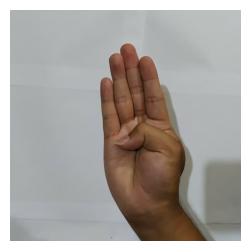

Image preprocessed. Making prediction...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
--- Prediction Results for "B (4).jpg" ---
Top 3 Predictions:
  1. U: 100.00%
  2. X: 0.00%
  3. K: 0.00%

--- Processing file: "/kaggle/input/new-predict/A (4).jpg" ---


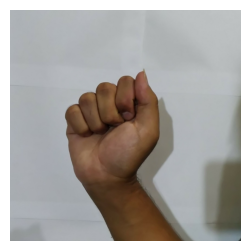

Image preprocessed. Making prediction...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
--- Prediction Results for "A (4).jpg" ---
Top 3 Predictions:
  1. S: 99.08%
  2. X: 0.75%
  3. T: 0.11%

--- Processing file: "/kaggle/input/new-predict/R (5).jpg" ---


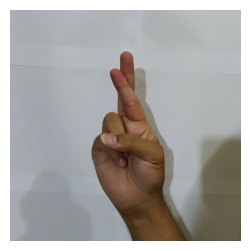

Image preprocessed. Making prediction...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
--- Prediction Results for "R (5).jpg" ---
Top 3 Predictions:
  1. R: 99.29%
  2. U: 0.69%
  3. O: 0.01%

--- Processing file: "/kaggle/input/new-predict/U (3).jpg" ---


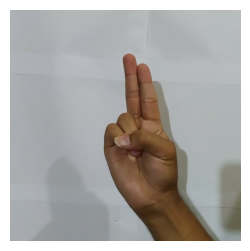

Image preprocessed. Making prediction...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
--- Prediction Results for "U (3).jpg" ---
Top 3 Predictions:
  1. U: 99.66%
  2. R: 0.34%
  3. X: 0.00%


In [24]:
save_model(model_cnn2, 'model_cnn2.pkl')
predict_images('model_cnn2.pkl', class_names, image_directory)

## CNN 3 

In [25]:
cnn3 = tf.keras.Sequential([
              tf.keras.Input(shape=(224, 224, 3)),
              data_augmentation,
              tf.keras.layers.Rescaling(1./255),
              tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
              tf.keras.layers.MaxPooling2D(),
              tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
              tf.keras.layers.MaxPooling2D(),
              tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
              tf.keras.layers.MaxPooling2D(),
              tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
              tf.keras.layers.MaxPooling2D(),
              tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
              tf.keras.layers.MaxPooling2D(),
              tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
              tf.keras.layers.MaxPooling2D(),
              tf.keras.layers.Flatten(),
              tf.keras.layers.Dense(128, activation='relu'),
              tf.keras.layers.Dense(num_classes, activation='softmax')
            ])
cnn3.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_2 (Rescaling)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 112, 112, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 56, 56, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 56, 56, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 28, 28, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 28, 28, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 14, 14, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 7, 7, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 3, 3, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 1152)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 128)                 │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 26)                  │           3,354 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 437,946 (1.67 MB)

 Trainable params: 437,946 (1.67 MB)

 Non-trainable params: 0 (0.00 B)


Start model training...

Epoch 1/20
650/650 ━━━━━━━━━━━━━━━━━━━━ 32s 41ms/step - accuracy: 0.2411 - loss: 2.4913 - val_accuracy: 0.9362 - val_loss: 0.1690 - learning_rate: 0.0010
Epoch 2/20
650/650 ━━━━━━━━━━━━━━━━━━━━ 26s 40ms/step - accuracy: 0.9173 - loss: 0.2557 - val_accuracy: 0.9873 - val_loss: 0.0386 - learning_rate: 0.0010
Epoch 3/20
650/650 ━━━━━━━━━━━━━━━━━━━━ 25s 39ms/step - accuracy: 0.9588 - loss: 0.1289 - val_accuracy: 0.9935 - val_loss: 0.0234 - learning_rate: 0.0010
Epoch 4/20
650/650 ━━━━━━━━━━━━━━━━━━━━ 26s 39ms/step - accuracy: 0.9695 - loss: 0.1043 - val_accuracy: 0.9977 - val_loss: 0.0094 - learning_rate: 0.0010
Epoch 5/20
650/650 ━━━━━━━━━━━━━━━━━━━━ 26s 39ms/step - accuracy: 0.9814 - loss: 0.0571 - val_accuracy: 0.9981 - val_loss: 0.0064 - learning_rate: 0.0010
Epoch 6/20
650/650 ━━━━━━━━━━━━━━━━━━━━ 26s 39ms/step - accuracy: 0.9844 - loss: 0.0510 - val_accuracy: 0.9996 - val_loss: 0.0029 - learning_rate: 0.0010
Epoch 7/20
650/650 ━━━━━━━━━━━━━━━━━━━━ 25s 39ms/s

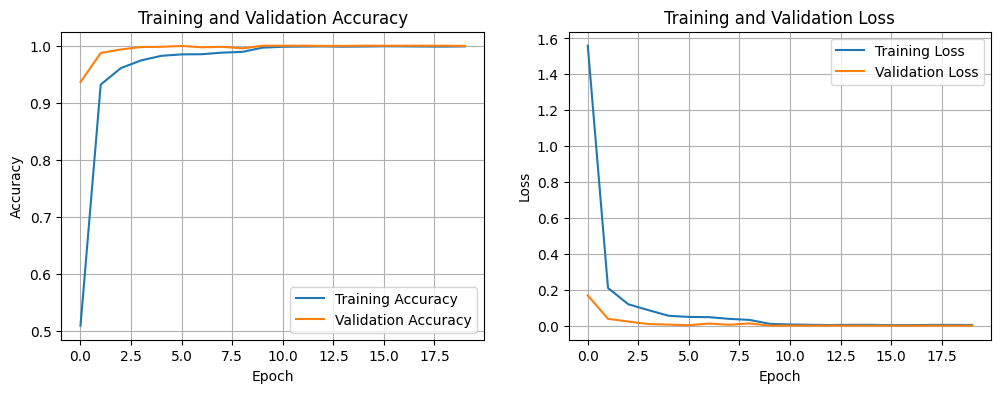

82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 1.0000 - loss: 7.3409e-05
Accuracy on test data: 1.0000
Loss on test data: 0.0001

82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step

Classification Report :
              precision    recall  f1-score   support

           A       1.00      1.00      1.00       100
           B       1.00      1.00      1.00       100
           C       1.00      1.00      1.00       100
           D       1.00      1.00      1.00       100
           E       1.00      1.00      1.00       100
           F       1.00      1.00      1.00       100
           G       1.00      1.00      1.00       100
           H       1.00      1.00      1.00       100
           I       1.00      1.00      1.00       100
           J       1.00      1.00      1.00       100
           K       1.00      1.00      1.00       100
           L       1.00      1.00      1.00       100
           M       1.00      1.00      1.00       100
           N       1.00      1.00      1.00

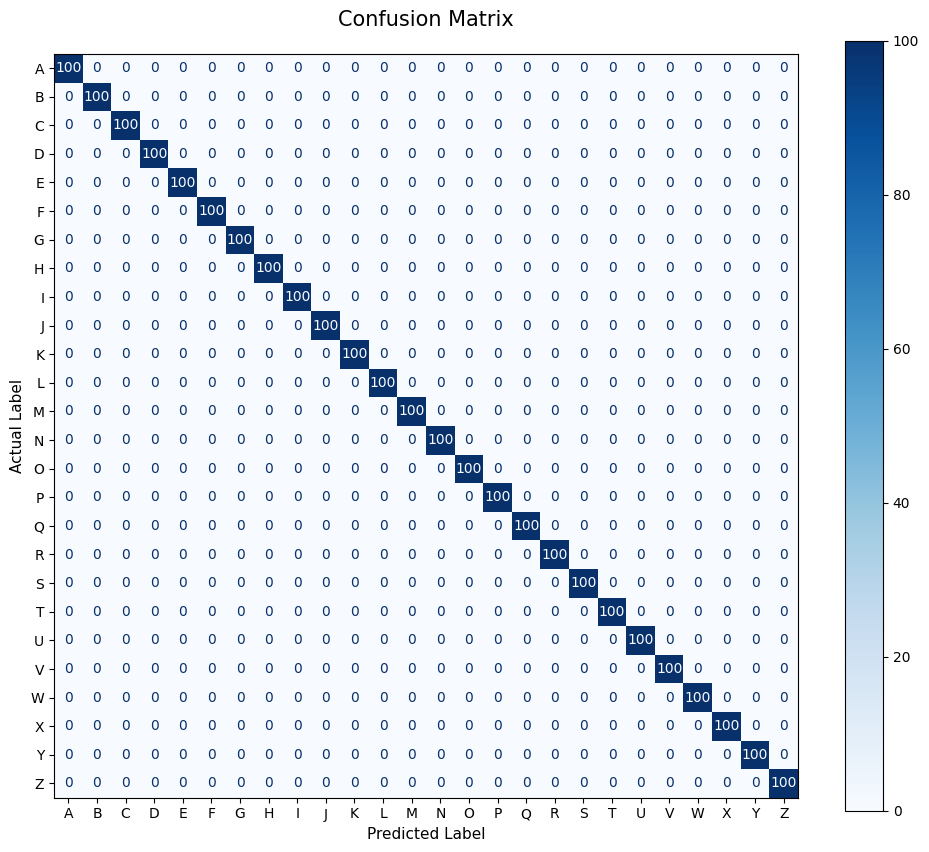

In [26]:
model_cnn3, model_cnn3_history = train_model(cnn3, train_data, val_data, epoch=20)
visualize_history(model_cnn3_history)
print_evaluation(model_cnn3, test_data, class_names)

Load model model_cnn3.pkl
Searching for images in: '/kaggle/input/new-predict'
Found 4 image(s).

--- Processing file: "/kaggle/input/new-predict/B (4).jpg" ---


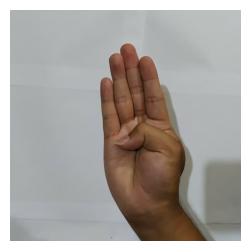

Image preprocessed. Making prediction...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
--- Prediction Results for "B (4).jpg" ---
Top 3 Predictions:
  1. B: 100.00%
  2. E: 0.00%
  3. U: 0.00%

--- Processing file: "/kaggle/input/new-predict/A (4).jpg" ---


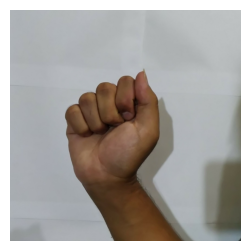

Image preprocessed. Making prediction...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
--- Prediction Results for "A (4).jpg" ---
Top 3 Predictions:
  1. A: 50.22%
  2. X: 44.85%
  3. S: 3.26%

--- Processing file: "/kaggle/input/new-predict/R (5).jpg" ---


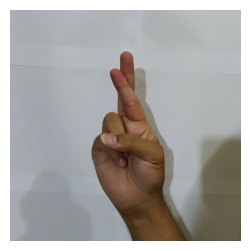

Image preprocessed. Making prediction...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
--- Prediction Results for "R (5).jpg" ---
Top 3 Predictions:
  1. R: 100.00%
  2. Z: 0.00%
  3. U: 0.00%

--- Processing file: "/kaggle/input/new-predict/U (3).jpg" ---


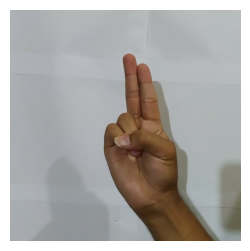

Image preprocessed. Making prediction...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
--- Prediction Results for "U (3).jpg" ---
Top 3 Predictions:
  1. U: 67.79%
  2. R: 32.21%
  3. X: 0.00%


In [27]:
save_model(model_cnn3, 'model_cnn3.pkl')
predict_images('model_cnn3.pkl', class_names, image_directory)

## CNN 4 

In [28]:
cnn4 = tf.keras.Sequential([
              tf.keras.Input(shape=(224, 224, 3)),
              data_augmentation,
              tf.keras.layers.Rescaling(1./255),
              tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
              tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
              tf.keras.layers.MaxPooling2D(),
              tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
              tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
              tf.keras.layers.MaxPooling2D(),
              tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
              tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
              tf.keras.layers.MaxPooling2D(),
              tf.keras.layers.Flatten(),
              tf.keras.layers.Dense(128, activation='relu'),
              tf.keras.layers.Dense(num_classes, activation='softmax')
            ])
cnn4.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_3 (Rescaling)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 224, 224, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 112, 112, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 56, 56, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 100352)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 128)                 │      12,845,184 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 26)                  │           3,354 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,135,546 (50.11 MB)

 Trainable params: 13,135,546 (50.11 MB)

 Non-trainable params: 0 (0.00 B)


Start model training...

Epoch 1/20
650/650 ━━━━━━━━━━━━━━━━━━━━ 91s 132ms/step - accuracy: 0.0379 - loss: 3.2705 - val_accuracy: 0.0385 - val_loss: 3.2581 - learning_rate: 0.0010
Epoch 2/20
650/650 ━━━━━━━━━━━━━━━━━━━━ 83s 128ms/step - accuracy: 0.0346 - loss: 3.2584 - val_accuracy: 0.0385 - val_loss: 3.2581 - learning_rate: 0.0010
Epoch 3/20
650/650 ━━━━━━━━━━━━━━━━━━━━ 83s 128ms/step - accuracy: 0.0345 - loss: 3.2585 - val_accuracy: 0.0385 - val_loss: 3.2581 - learning_rate: 0.0010
Epoch 4/20
650/650 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.0336 - loss: 3.2585
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
650/650 ━━━━━━━━━━━━━━━━━━━━ 83s 128ms/step - accuracy: 0.0336 - loss: 3.2585 - val_accuracy: 0.0385 - val_loss: 3.2581 - learning_rate: 0.0010
Epoch 5/20
650/650 ━━━━━━━━━━━━━━━━━━━━ 83s 128ms/step - accuracy: 0.0350 - loss: 3.2583 - val_accuracy: 0.0385 - val_loss: 3.2581 - learning_rate: 1.0000e-04
Epoch 6/20
650/650 ━━━━━━━━━━━━━━━━━━━━ 8

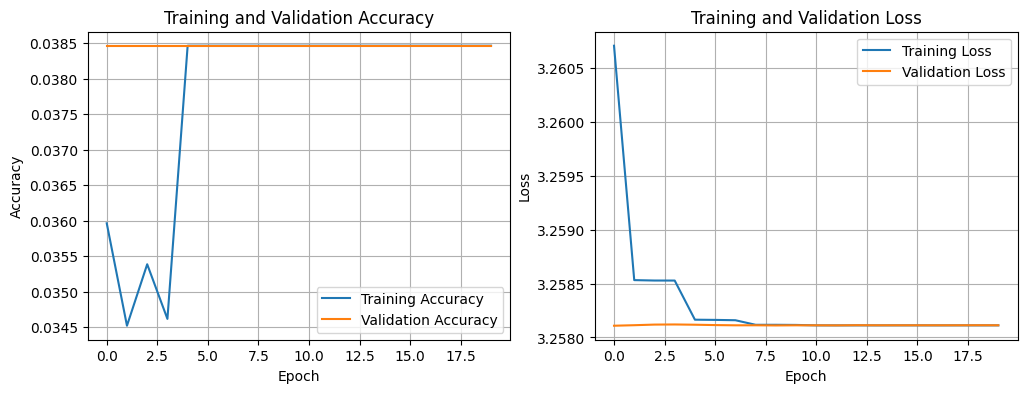

82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.0033 - loss: 3.2578
Accuracy on test data: 0.0385
Loss on test data: 3.2581

82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step

Classification Report :
              precision    recall  f1-score   support

           A       0.00      0.00      0.00       100
           B       0.00      0.00      0.00       100
           C       0.00      0.00      0.00       100
           D       0.00      0.00      0.00       100
           E       0.00      0.00      0.00       100
           F       0.00      0.00      0.00       100
           G       0.00      0.00      0.00       100
           H       0.00      0.00      0.00       100
           I       0.00      0.00      0.00       100
           J       0.00      0.00      0.00       100
           K       0.00      0.00      0.00       100
           L       0.00      0.00      0.00       100
           M       0.00      0.00      0.00       100
           N       0.00      0.00      0.00    

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


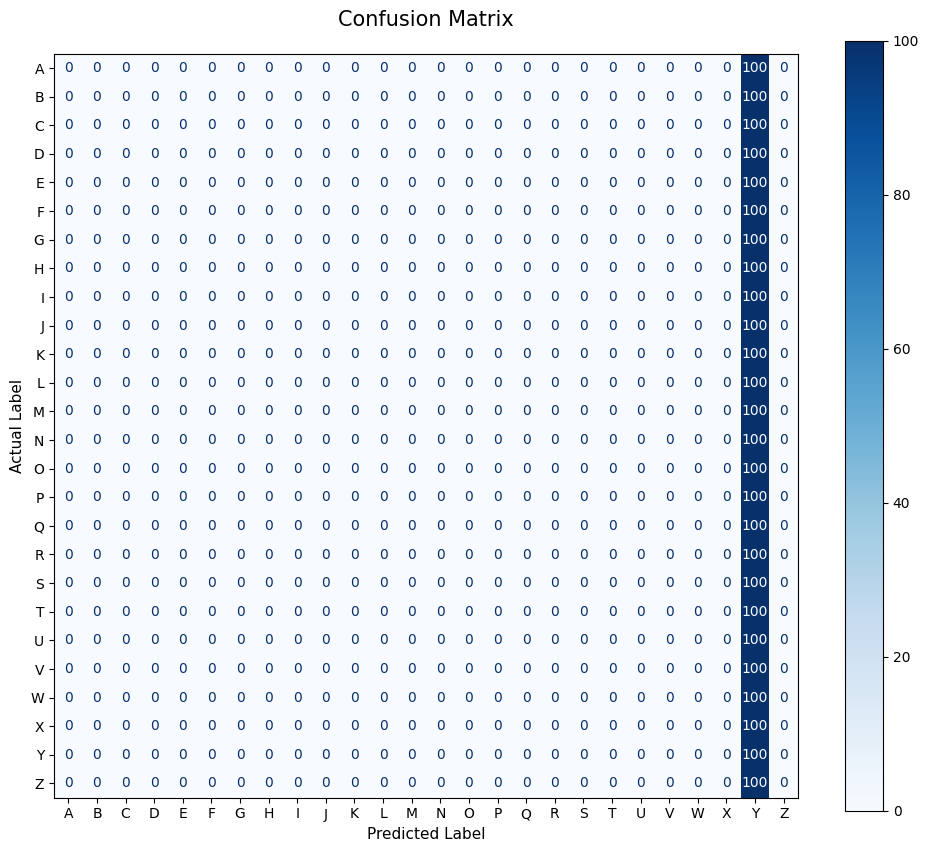

In [29]:
model_cnn4, model_cnn4_history = train_model(cnn4, train_data, val_data, epoch=20)
visualize_history(model_cnn4_history)
print_evaluation(model_cnn4, test_data, class_names)

Load model model_cnn4.pkl
Searching for images in: '/kaggle/input/new-predict'
Found 4 image(s).

--- Processing file: "/kaggle/input/new-predict/B (4).jpg" ---


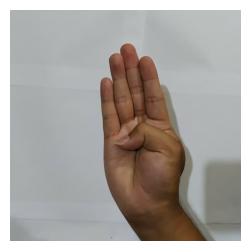

Image preprocessed. Making prediction...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step
--- Prediction Results for "B (4).jpg" ---
Top 3 Predictions:
  1. Y: 3.89%
  2. O: 3.87%
  3. X: 3.87%

--- Processing file: "/kaggle/input/new-predict/A (4).jpg" ---


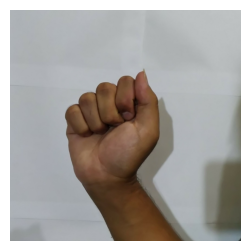

Image preprocessed. Making prediction...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
--- Prediction Results for "A (4).jpg" ---
Top 3 Predictions:
  1. Y: 3.89%
  2. O: 3.87%
  3. X: 3.87%

--- Processing file: "/kaggle/input/new-predict/R (5).jpg" ---


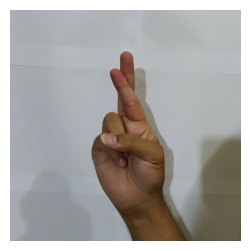

Image preprocessed. Making prediction...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
--- Prediction Results for "R (5).jpg" ---
Top 3 Predictions:
  1. Y: 3.89%
  2. O: 3.87%
  3. X: 3.87%

--- Processing file: "/kaggle/input/new-predict/U (3).jpg" ---


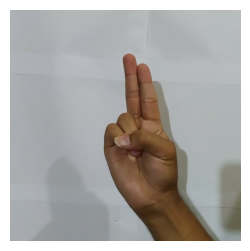

Image preprocessed. Making prediction...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
--- Prediction Results for "U (3).jpg" ---
Top 3 Predictions:
  1. Y: 3.89%
  2. O: 3.87%
  3. X: 3.87%


In [30]:
save_model(model_cnn4, 'model_cnn4.pkl')
predict_images('model_cnn4.pkl', class_names, image_directory)